## Importando as bibliotecas necessarias:

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/felipe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funcao para visualizar imagens a partir dos tensores e configuracoes iniciais:

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


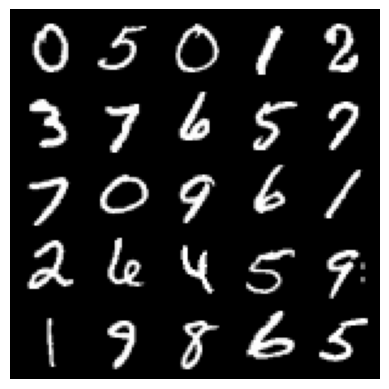

In [7]:
def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

# Display images from train_loader
dataiter = iter(train_loader)
images,labels = next(dataiter)
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)



## Declarando o Gerador e o Discriminador:

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1) #change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)
    
class Discriminator(nn.Module):
    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride)
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1) # returns 1-dimension tensor representing fake/real

## Hiperparametros, Otimizador e Funcao de perda:

In [9]:
display_step = 1000

epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

z_dim = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

beta_1 = 0.5 # parameters control the optimizer's momentum
beta_2 = 0.999 # parameters control the optimizer's momentum

G_opt = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss

## Treinamento:

 13%|█▎        | 62/469 [00:07<00:42,  9.47it/s]

Step 1000: Generator loss: 2.314653914868834, discriminator loss: 0.20901470509637157


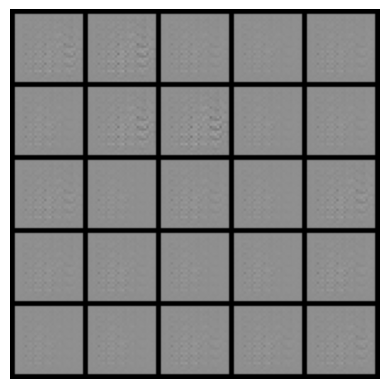

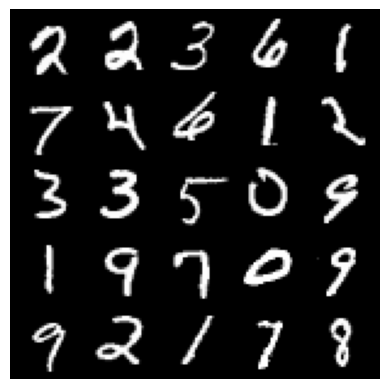

 26%|██▋       | 124/469 [00:17<00:52,  6.59it/s]

Step 2000: Generator loss: 4.438668239064511, discriminator loss: 0.05911273909732698


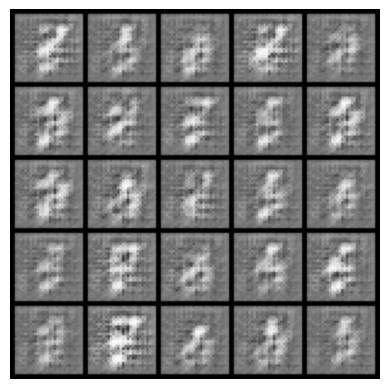

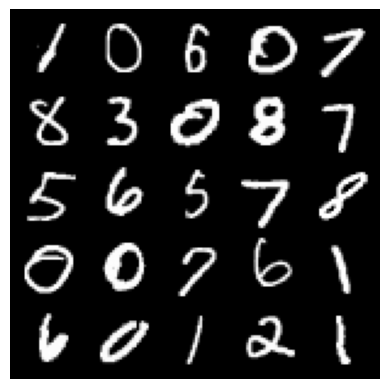

 40%|███▉      | 186/469 [00:24<00:37,  7.59it/s]

Step 3000: Generator loss: 2.3496798743754623, discriminator loss: 0.262279758669436


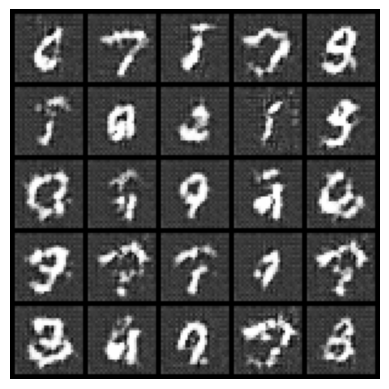

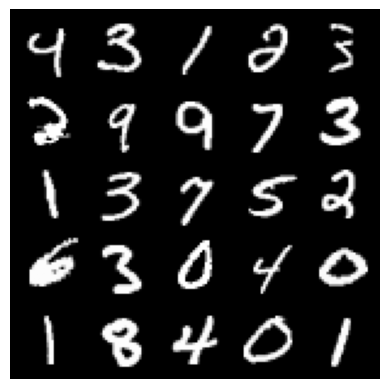

 53%|█████▎    | 248/469 [00:31<00:31,  7.07it/s]

Step 4000: Generator loss: 1.7614155846163633, discriminator loss: 0.33980141897499566


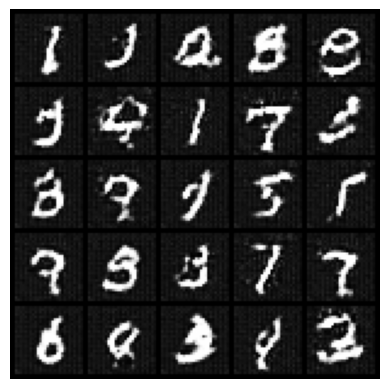

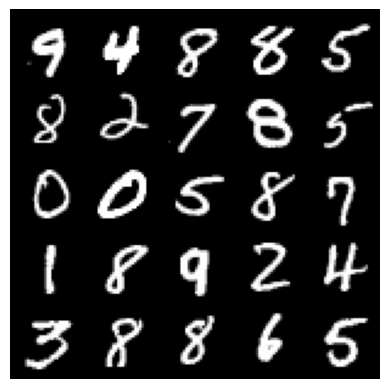

 66%|██████▌   | 310/469 [00:43<00:21,  7.28it/s]

Step 5000: Generator loss: 1.453236661344766, discriminator loss: 0.3868211592733856


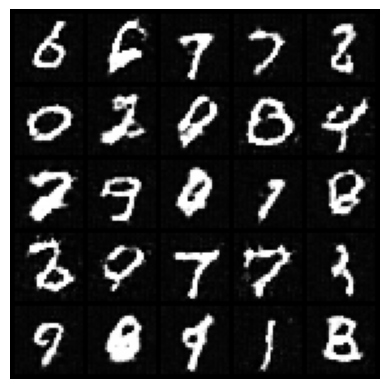

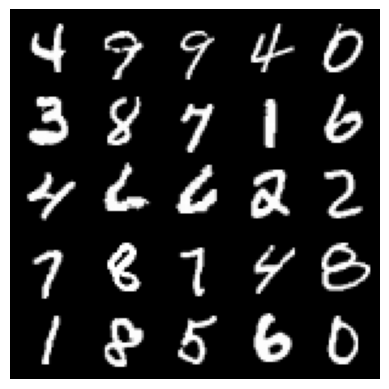

 79%|███████▉  | 372/469 [00:50<00:13,  7.34it/s]

Step 6000: Generator loss: 1.400543560042977, discriminator loss: 0.40176558193564466


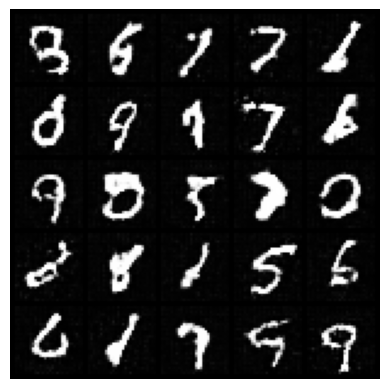

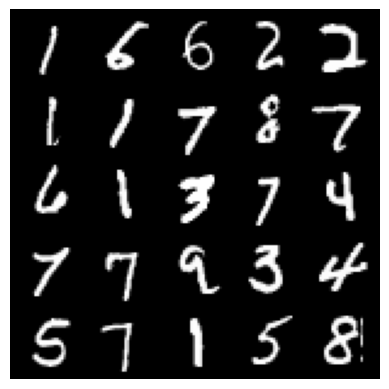

 93%|█████████▎| 434/469 [00:58<00:04,  7.31it/s]

Step 7000: Generator loss: 1.4017360902428633, discriminator loss: 0.40452763229608596


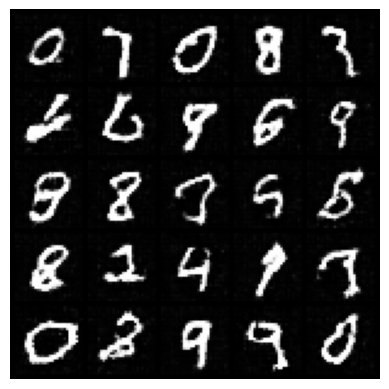

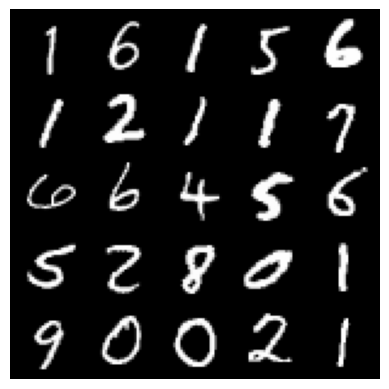

  6%|▌         | 27/469 [00:03<00:56,  7.80it/s]

Step 8000: Generator loss: 1.4217926301658166, discriminator loss: 0.4027957829535011


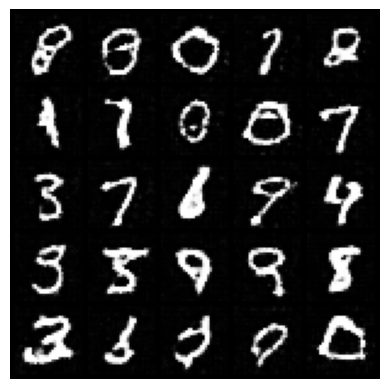

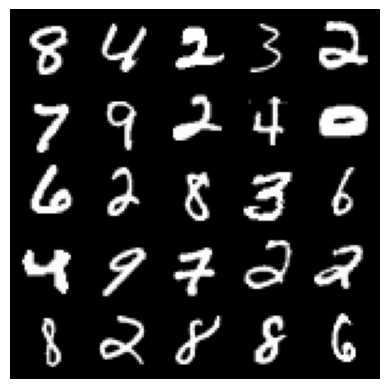

 19%|█▉        | 89/469 [00:10<00:45,  8.42it/s]

Step 9000: Generator loss: 1.4329206766784177, discriminator loss: 0.40194806858897214


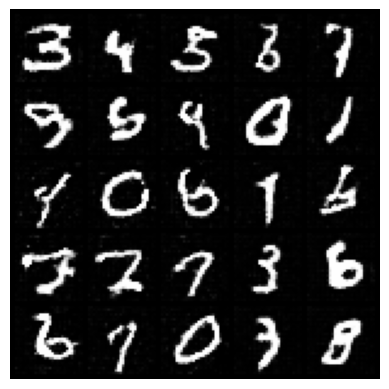

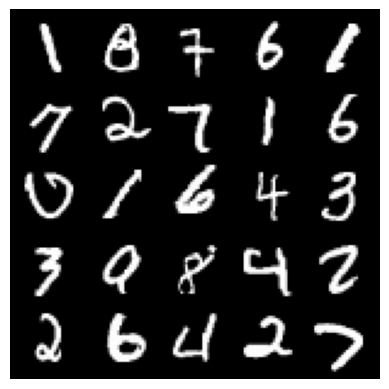

 32%|███▏      | 151/469 [00:20<00:38,  8.29it/s]

Step 10000: Generator loss: 1.4495790439248086, discriminator loss: 0.3971336972713469


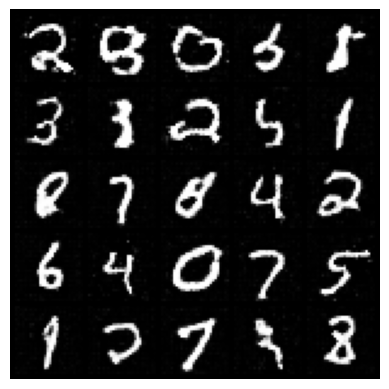

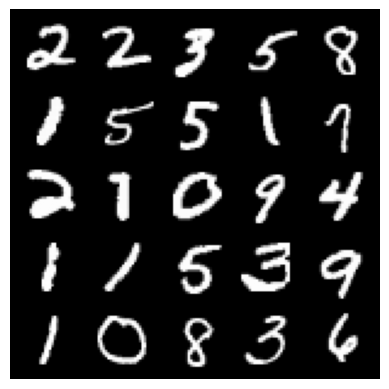

 45%|████▌     | 213/469 [00:28<00:35,  7.13it/s]

Step 11000: Generator loss: 1.4307992904484272, discriminator loss: 0.40673255288601


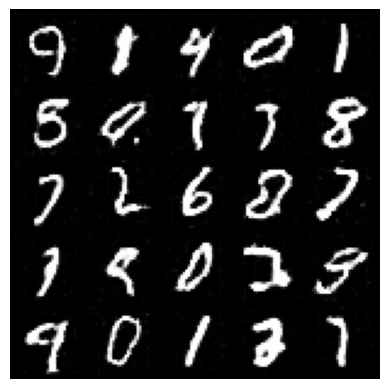

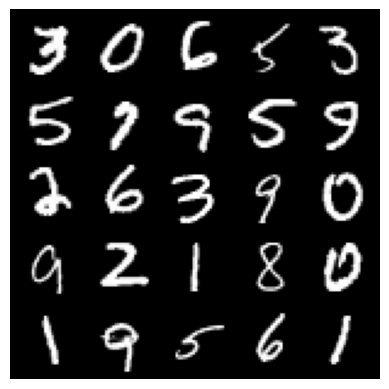

 59%|█████▊    | 275/469 [00:27<00:23,  8.19it/s]

Step 12000: Generator loss: 1.4178810827434052, discriminator loss: 0.414124936610461


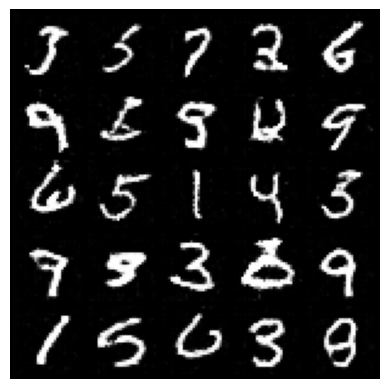

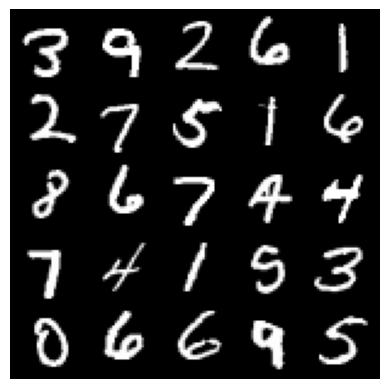

 72%|███████▏  | 337/469 [00:37<00:12, 10.24it/s]

Step 13000: Generator loss: 1.3986097554564496, discriminator loss: 0.430217040866613


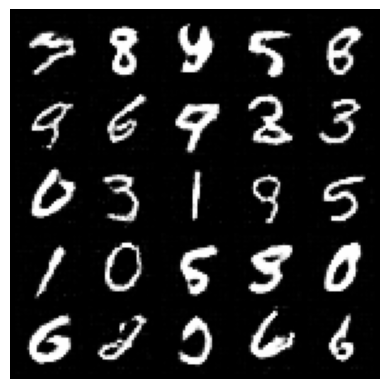

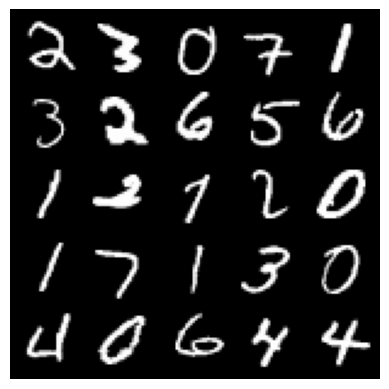

 85%|████████▌ | 399/469 [00:43<00:07,  9.97it/s]

Step 14000: Generator loss: 1.3856199158430083, discriminator loss: 0.4354007270634174


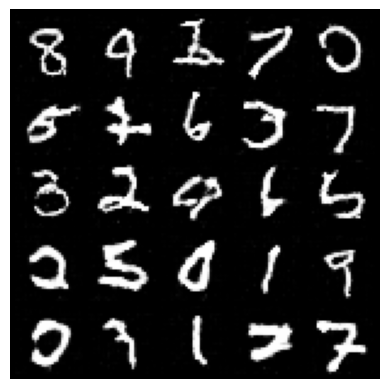

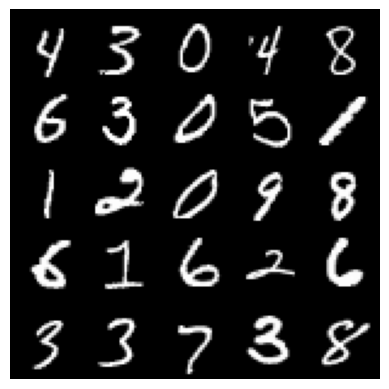

 98%|█████████▊| 461/469 [00:58<00:00,  9.27it/s]

Step 15000: Generator loss: 1.3685297534763805, discriminator loss: 0.44262782016396535


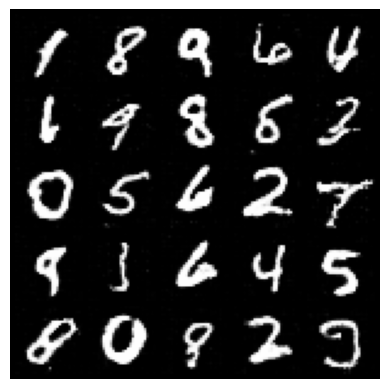

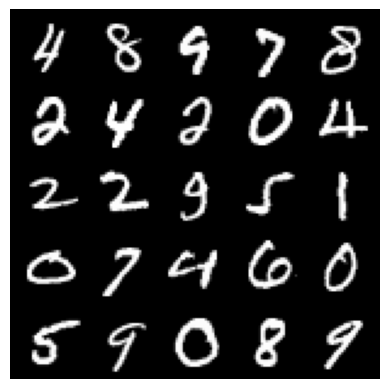

 12%|█▏        | 54/469 [00:07<00:51,  8.06it/s]

Step 16000: Generator loss: 1.3396976647675007, discriminator loss: 0.4565531296432023


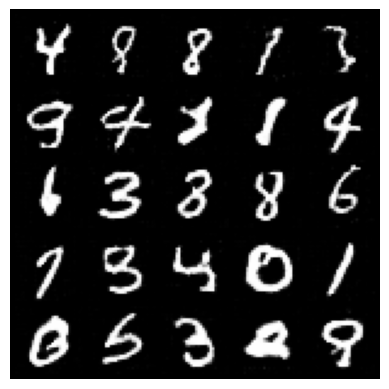

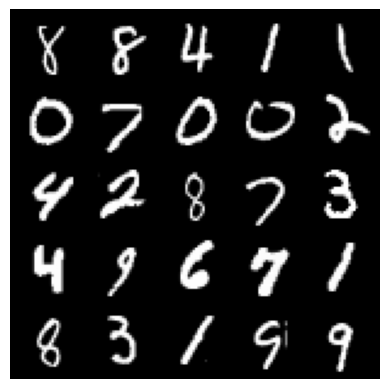

 25%|██▍       | 116/469 [00:11<00:37,  9.35it/s]

Step 17000: Generator loss: 1.3068722927272296, discriminator loss: 0.472999499201775


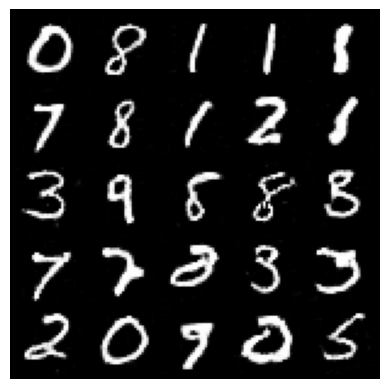

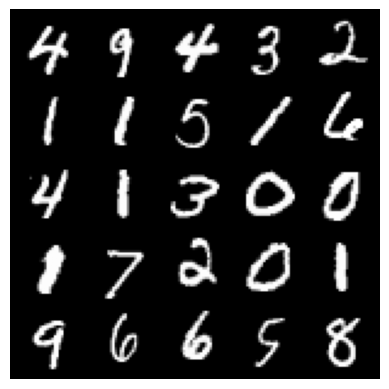

 38%|███▊      | 178/469 [00:19<00:30,  9.69it/s]

Step 18000: Generator loss: 1.2697609344720828, discriminator loss: 0.48204092928767167


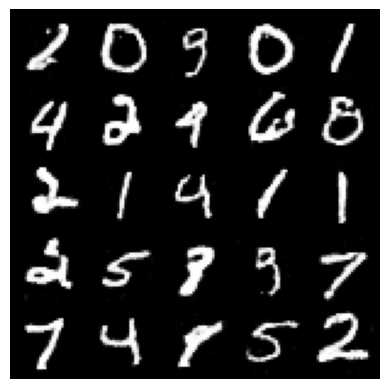

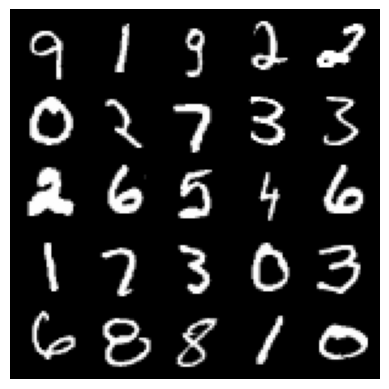

 51%|█████     | 240/469 [00:24<00:21, 10.53it/s]

Step 19000: Generator loss: 1.24691613584757, discriminator loss: 0.4957518630325798


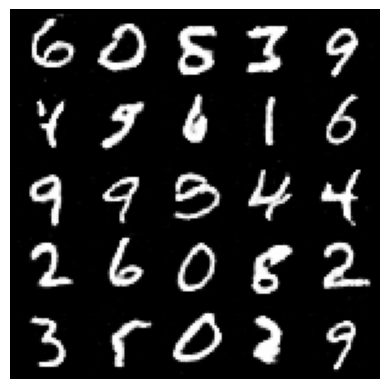

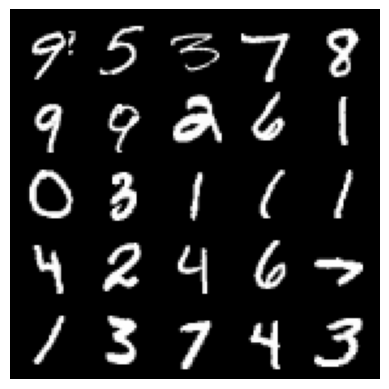

 64%|██████▍   | 301/469 [00:30<00:16, 10.21it/s]

Step 20000: Generator loss: 1.233820921391249, discriminator loss: 0.5025808589756484


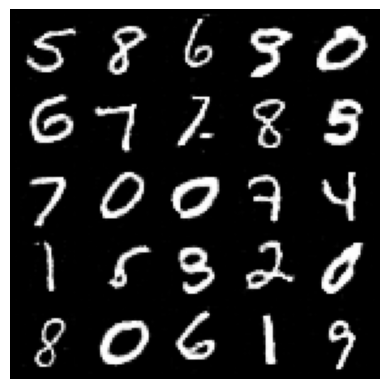

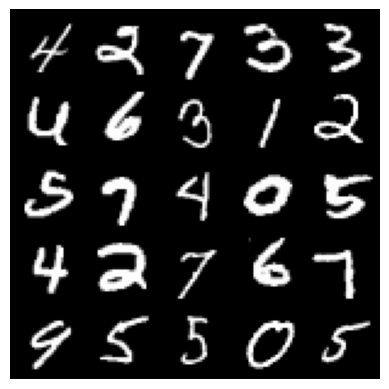

 77%|███████▋  | 363/469 [00:35<00:10, 10.16it/s]

Step 21000: Generator loss: 1.210921541720629, discriminator loss: 0.5053530798554419


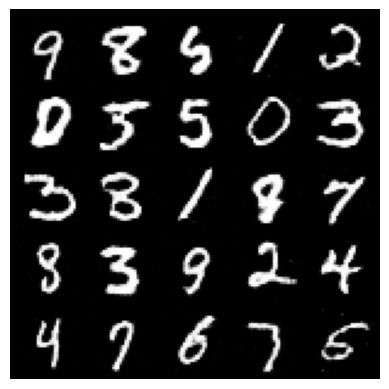

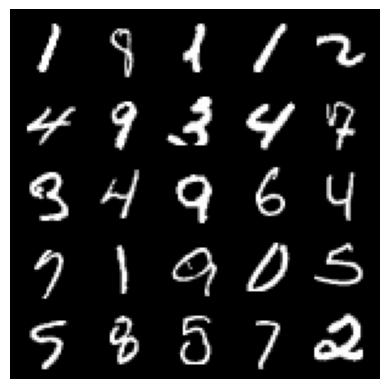

 91%|█████████ | 426/469 [00:41<00:04,  9.61it/s]

Step 22000: Generator loss: 1.1858283223211772, discriminator loss: 0.5164024915695191


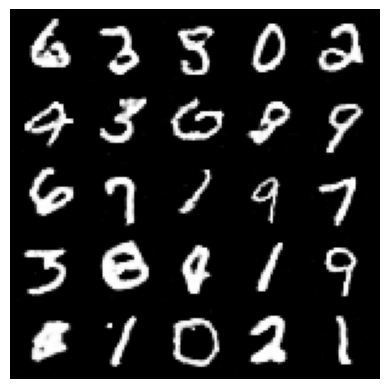

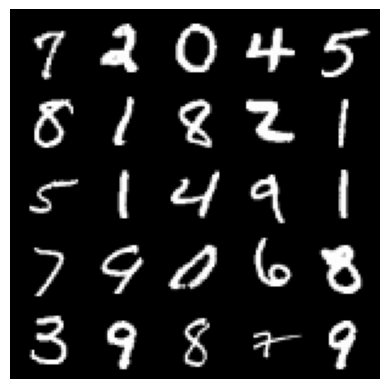

  4%|▍         | 19/469 [00:01<00:44, 10.16it/s]

Step 23000: Generator loss: 1.1838685776889328, discriminator loss: 0.5198903791904457


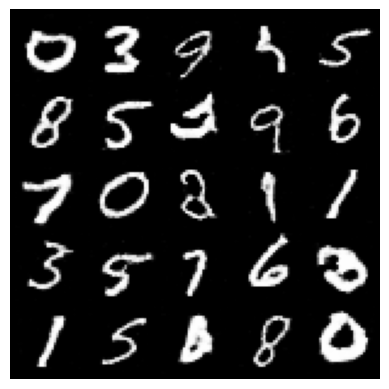

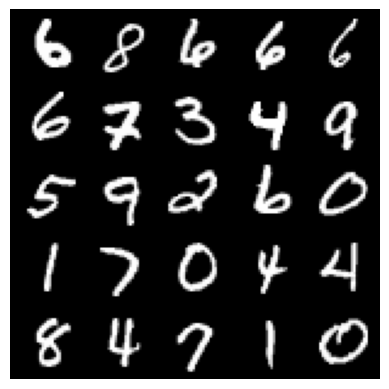

100%|██████████| 469/469 [00:46<00:00, 10.14it/s]


In [10]:
for epoch in range(epochs):
    for real_img,_ in tqdm(train_loader):

        batch_size = real_img.size(0)
        real_img = real_img.to(device)

        #  Update Discriminator  #
        D_opt.zero_grad()

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img.detach())
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2
        mean_discriminator_loss += D_loss.item() / display_step    # Keep track of the average discriminator loss

        D_loss.backward(retain_graph=True)
        D_opt.step()

        # Update Generator #
        G_opt.zero_grad()
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        mean_generator_loss += G_loss.item() / display_step     # Keep track of the average generator loss

        G_loss.backward()
        G_opt.step()

        # Visualization #
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_img)
            show_tensor_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

## Salvando resultados:

In [42]:
for i in range(2000, 3000):
    noise = torch.randn(batch_size, z_dim, device=device)
    sample = G(noise)
    tensor_img = (sample + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:1], nrow=5)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.savefig(f"images_convgan/image_convgan{i}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

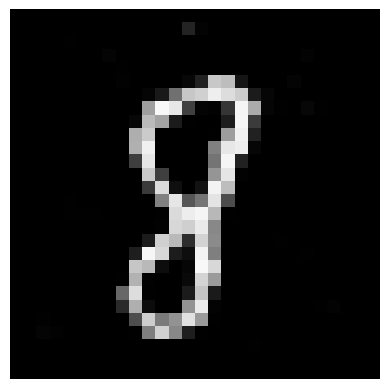

In [45]:
noise = torch.randn(batch_size, z_dim, device=device)
sample = G(noise)

show_tensor_images(sample, num_img=1)